<a href="https://colab.research.google.com/github/RotichG/Fraud-Detection/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Online Identity Theft Detection Using Logistic Regression**

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor

from sklearn.linear_model import LogisticRegression


In [4]:
transaction_df= pd.read_csv('/content/drive/MyDrive/FraudDataset/train_transaction.csv') 
identity_df= pd.read_csv('/content/drive/MyDrive/FraudDataset/train_identity.csv')
df_train=pd.merge(transaction_df, identity_df, on="TransactionID", how="left")


In [5]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [6]:
test_transaction= pd.read_csv('/content/drive/MyDrive/FraudDataset/test_transaction.csv') 
test_identity= pd.read_csv('/content/drive/MyDrive/FraudDataset/test_identity.csv')
df_test=pd.merge(transaction_df, identity_df, on="TransactionID", how="left")

In [7]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.float_format',lambda x: '%.2f'% x)
pd.set_option('display.width',400)

In [8]:
print ("Train shape",df_train.shape)
print ("Test shape",df_test.shape)

Train shape (590540, 434)
Test shape (590540, 434)


# Reduce memory use 


In [10]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

Using the reduction memory usage for the train and test dataframes

In [11]:
df_train= reduce_mem_usage(df_train)
df_test= reduce_mem_usage(df_test)


Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 650.48 Mb (66.8% reduction)


# Data Preprocessing
This section is comprises exploring the availed categorical features, data cleaning and filling in missing values.

In [12]:
print('Training set:')
for col_name in df_train.columns:
    if df_train[col_name].dtypes == 'object' :
        unique_cat = len(df_train[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Training set:
Feature 'ProductCD' has 5 categories
Feature 'card4' has 5 categories
Feature 'card6' has 5 categories
Feature 'P_emaildomain' has 60 categories
Feature 'R_emaildomain' has 61 categories
Feature 'M1' has 3 categories
Feature 'M2' has 3 categories
Feature 'M3' has 3 categories
Feature 'M4' has 4 categories
Feature 'M5' has 3 categories
Feature 'M6' has 3 categories
Feature 'M7' has 3 categories
Feature 'M8' has 3 categories
Feature 'M9' has 3 categories
Feature 'id_12' has 3 categories
Feature 'id_15' has 4 categories
Feature 'id_16' has 3 categories
Feature 'id_23' has 4 categories
Feature 'id_27' has 3 categories
Feature 'id_28' has 3 categories
Feature 'id_29' has 3 categories
Feature 'id_30' has 76 categories
Feature 'id_31' has 131 categories
Feature 'id_33' has 261 categories
Feature 'id_34' has 5 categories
Feature 'id_35' has 3 categories
Feature 'id_36' has 3 categories
Feature 'id_37' has 3 categories
Feature 'id_38' has 3 categories
Feature 'DeviceType' has 3 ca

In [13]:
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'ProductCD' has 5 categories
Feature 'card4' has 5 categories
Feature 'card6' has 5 categories
Feature 'P_emaildomain' has 60 categories
Feature 'R_emaildomain' has 61 categories
Feature 'M1' has 3 categories
Feature 'M2' has 3 categories
Feature 'M3' has 3 categories
Feature 'M4' has 4 categories
Feature 'M5' has 3 categories
Feature 'M6' has 3 categories
Feature 'M7' has 3 categories
Feature 'M8' has 3 categories
Feature 'M9' has 3 categories
Feature 'id_12' has 3 categories
Feature 'id_15' has 4 categories
Feature 'id_16' has 3 categories
Feature 'id_23' has 4 categories
Feature 'id_27' has 3 categories
Feature 'id_28' has 3 categories
Feature 'id_29' has 3 categories
Feature 'id_30' has 76 categories
Feature 'id_31' has 131 categories
Feature 'id_33' has 261 categories
Feature 'id_34' has 5 categories
Feature 'id_35' has 3 categories
Feature 'id_36' has 3 categories
Feature 'id_37' has 3 categories
Feature 'id_38' has 3 categories
Feature 'DeviceType' has 3 catego

In [14]:
df_train.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
TransactionID,590540.00,3282269.50,170474.36,2987000.00,3134634.75,3282269.50,3429904.25,3577539.00
isFraud,590540.00,0.03,0.18,0.00,0.00,0.00,0.00,1.00
TransactionDT,590540.00,7372311.31,4617223.65,86400.00,3027057.75,7306527.50,11246620.00,15811131.00
TransactionAmt,590540.00,NaN,NaN,0.25,43.31,68.75,125.00,31936.00
card1,590540.00,9898.73,4901.17,1000.00,6019.00,9678.00,14184.00,18396.00
card2,581607.00,NaN,NaN,100.00,214.00,361.00,512.00,600.00
card3,588975.00,NaN,0.00,100.00,150.00,150.00,150.00,231.00
card5,586281.00,NaN,0.00,100.00,166.00,226.00,226.00,237.00
addr1,524834.00,NaN,NaN,100.00,204.00,299.00,330.00,540.00
addr2,524834.00,NaN,0.00,10.00,87.00,87.00,87.00,102.00


In [15]:
cat_col= [col for col in df_train.columns if df_train[col].dtype in ['object']]
df_train[cat_col].describe()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,590540,588963,588969,496084,137291,319440,319440,319440,309096,240058,421180,244275,244288,244288,144233,140985,129340,5169,5169,140978,140978,77565,140282,73289,77805,140985,140985,140985,140985,140810,118666
unique,5,4,4,59,60,2,2,2,3,2,2,2,2,2,2,3,2,3,2,2,2,75,130,260,4,2,2,2,2,2,1786
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,F,F,F,T,NotFound,Found,Found,IP_PROXY:TRANSPARENT,Found,Found,Found,Windows 10,chrome 63.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
freq,439670,384767,439938,228355,57147,319415,285468,251731,196405,132491,227856,211374,155251,205656,123025,67728,66324,3489,5155,76232,74926,21155,22000,16874,60011,77814,134066,110452,73922,85165,47722


Fraud Detection is an imbalance dataset since the disparity in numbers of non-fraudelent versus fraudulent cases is significant.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Fraudulent vs legitimate Transaction


0   96.50
1    3.50
Name: isFraud, dtype: float64

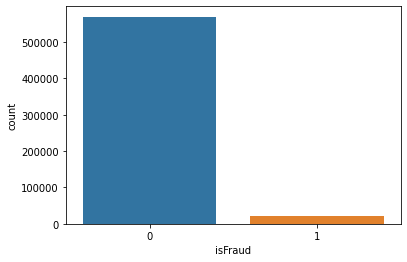

In [16]:
sns.countplot(df_train['isFraud'])
print("Fraudulent vs legitimate Transaction")
df_train['isFraud'].value_counts(normalize=True) * 100

Get the percentage of fraudulent records in the dataset


In [20]:
fraud_percent=len(df_train[df_train['isFraud']==1].index)*100/df_train.shape[0]
print("% fraudulent records={:.2f}".format(fraud_percent))

% fraudulent records=3.50


Data Cleaning: Missing values

In [23]:
def missing_data(df):
  count= df.isnull().sum()
  percent= (df.isnull().sum()) / (df.isnull().count())*100
  total= pd.concat([count, percent], axis=1, keys =['count', 'percent'])
  types=[]
  for col in df.columns:
    dtypes = str(df[col].dtype)
    types.append(dtypes)
    total['dtypes']= types

    return np.transpose(total)
    missing_data(df_train)

In [25]:
# Dropping columns with more than 50% null value
null_percent = df_train.isnull().sum()/df_train.shape[0]*100
drop_cols= np.array(null_percent[null_percent > 80].index)
drop_cols

array(['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138',
       'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146',
       'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154',
       'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162',
       'V163', 'V164', 'V165', 'V166', 'V322', 'V323', 'V324', 'V325',
       'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333',
       'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'id_03', 'id_04',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18', 'id_21',
       'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30',
       'id_32', 'id_33', 'id_34'], dtype=object)

In [27]:
df_train= df_train.drop(drop_cols,axis=1)
df_test=df_test.drop(drop_cols,axis=1)


In [28]:
print(df_train.shape)
print(df_test.shape)

(590540, 360)
(590540, 360)


In [29]:
df_train= df_train.fillna(-999)
df_test= df_test.fillna(-999)

In [30]:
train_y= df_train['isFraud']
train_x= df_train.drop('isFraud',axis=1)

In [34]:
for f in train_x.columns:
  if train_x[f].dtype== 'object' or df_test[f].dtype=='object':
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_x[f].values)+ list(df_test[f].values))
    train_x[f]= lbl.transform(list(train_x[f].values))
    df_test[f]= lbl.transform(list(df_test[f].values))


Base Model - Logistic Regression


In [ ]:
logreg= LogisticRegression()
logreg.fit(train_x,train_y)